## Accessing Sentinel-5P data with the Planetary Computer STAC API

The Copernicus [Sentinel-5 Precursor](https://sentinels.copernicus.eu/web/sentinel/missions/sentinel-5p) mission provides high spatio-temporal resolution measurements of the Earth's atmosphere. Sentinel-5P Level-2 data products include total columns of ozone, sulfur dioxide, nitrogen dioxide, carbon monoxide and formaldehyde, tropospheric columns of ozone, vertical profiles of ozone and cloud & aerosol information. The Planetary Computer's [`sentinel-5p-l2-netcdf`](https://planetarycomputer.microsoft.com/dataset/sentinel-5p-l2-netcdf) STAC Collection contains Items for thirteen Sentinel-5P Level-2 products in NetCDF format:

* [`L2__AER_AI`](http://www.tropomi.eu/data-products/uv-aerosol-index): Ultraviolet aerosol index
* [`L2__AER_LH`](http://www.tropomi.eu/data-products/aerosol-layer-height): Aerosol layer height
* [`L2__CH4___`](http://www.tropomi.eu/data-products/methane): Methane (CH<sub>4</sub>) total column
* [`L2__CLOUD_`](http://www.tropomi.eu/data-products/cloud): Cloud fraction, albedo, and top pressure
* [`L2__CO____`](http://www.tropomi.eu/data-products/carbon-monoxide): Carbon monoxide (CO) total column
* [`L2__HCHO__`](http://www.tropomi.eu/data-products/formaldehyde): Formaldehyde (HCHO) total column
* [`L2__NO2___`](http://www.tropomi.eu/data-products/nitrogen-dioxide): Nitrogen dioxide (NO<sub>2</sub>) total column
* [`L2__O3____`](http://www.tropomi.eu/data-products/total-ozone-column): Ozone (O<sub>3</sub>) total column
* [`L2__O3_TCL`](http://www.tropomi.eu/data-products/tropospheric-ozone-column): Ozone (O<sub>3</sub>) tropospheric column
* [`L2__SO2___`](http://www.tropomi.eu/data-products/sulphur-dioxide): Sulfur dioxide (SO<sub>2</sub>) total column
* [`L2__NP_BD3`](http://www.tropomi.eu/data-products/auxiliary): Cloud from the Suomi NPP mission, band 3
* [`L2__NP_BD6`](http://www.tropomi.eu/data-products/auxiliary): Cloud from the Suomi NPP mission, band 6
* [`L2__NP_BD7`](http://www.tropomi.eu/data-products/auxiliary): Cloud from the Suomi NPP mission, band 7

### Environment setup

This notebook works with or without an API key, but you will be given more permissive access to the data with an API key. If you are using the [Planetary Computer Hub](https://planetarycomputer.microsoft.com/compute) to run this notebook, then your API key is automatically set to the environment variable `PC_SDK_SUBSCRIPTION_KEY` for you when your server is started. Otherwise, you can view your keys by signing in to the [developer portal](https://planetarycomputer.developer.azure-api.net/). The API key may be manually set via the environment variable `PC_SDK_SUBSCRIPTION_KEY` or the following code:

```python
import planetary_computer
planetary_computer.settings.set_subscription_key(<YOUR API Key>)
```

In [1]:
pip install rioxarray --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
import cartopy.crs as ccrs
import fsspec
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import planetary_computer
import pystac_client
import xarray as xr
import rioxarray

### Data access

The datasets hosted by the Planetary Computer are available from [Azure Blob Storage](https://docs.microsoft.com/en-us/azure/storage/blobs/). We'll use [pystac-client](https://pystac-client.readthedocs.io/) to search the Planetary Computer's [STAC API](https://planetarycomputer.microsoft.com/api/stac/v1/docs) for the subset of the data that we care about, and then we'll load the data directly from Azure Blob Storage. We'll specify a `modifier` so that we can access the data stored in the Planetary Computer's private Blob Storage Containers. See [Reading from the STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) and [Using tokens for data access](https://planetarycomputer.microsoft.com/docs/concepts/sas/) for more.

In [3]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

### Select an area, time, and product type and find STAC Items

Let's search for Items containing the formaldehyde product (`L2__HCHO__`) over the country of India. We'll further limit our search to an arbitrary collection date of April 2, 2023 and only include data that has been processed "offline" (`OFFL`). The geospatial extents of `OFFL` Items are much larger than those processed in near real-time (`NRTI`).

In [4]:
latitude = 42.0000
longitude = -93.6500

geometry = {
    "type": "Point",
    "coordinates": [longitude, latitude],
}

search = catalog.search(
    collections="sentinel-5p-l2-netcdf",
    intersects=geometry,
    datetime="2023-04-02/2023-04-03",
    query={"s5p:processing_mode": {"eq": "OFFL"}, "s5p:product_name": {"eq": "o3"}},
)
items = list(search.items())

print(f"Found {len(items)} items:")
for item in items:
    print(f"- {item.id} ({item.datetime})")
    

Found 2 items:
- S5P_L2_O3_____20230403T182337_20230403T200508_28352 (2023-04-03 19:14:23+00:00)
- S5P_L2_O3_____20230402T184230_20230402T202401_28338 (2023-04-02 19:33:16.500000+00:00)


Let's take a look at the first Item in the list.

In [5]:
f = fsspec.open(items[0].assets["o3"].href).open()
ds = xr.open_dataset(f, group="PRODUCT", engine="h5netcdf")
ds

<xarray.Dataset> Size: 53MB
Dimensions:                                (scanline: 4173, ground_pixel: 450,
                                            time: 1, corner: 4, layer: 14,
                                            level: 15)
Coordinates:
  * scanline                               (scanline) float64 33kB 0.0 ... 4....
  * ground_pixel                           (ground_pixel) float64 4kB 0.0 ......
  * time                                   (time) datetime64[ns] 8B 2023-04-03
  * corner                                 (corner) float64 32B 0.0 1.0 2.0 3.0
  * layer                                  (layer) int32 56B 0 1 2 ... 11 12 13
  * level                                  (level) int32 60B 0 1 2 ... 12 13 14
Data variables:
    latitude                               (time, scanline, ground_pixel) float32 8MB ...
    longitude                              (time, scanline, ground_pixel) float32 8MB ...
    delta_time                             (time, scanline, ground_pixel) datetime64[ns] 15MB ...
    time_utc                               (time, scanline) object 33kB ...
    qa_value                               (time, scanline, ground_pixel) float32 8MB ...
    ozone_total_vertical_column            (time, scanline, ground_pixel) float32 8MB ...
    ozone_total_vertical_column_precision  (time, scanline, ground_pixel) float32 8MB ...

Plotting the data in its native coordinate system is not very informative.

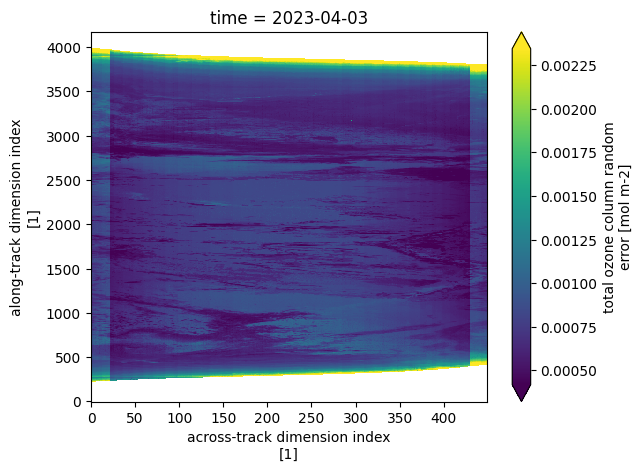

In [6]:
varname = "ozone_total_vertical_column_precision"
data = ds[varname][0, :, :]
vmin, vmax = np.nanpercentile(data, [1, 99])
data.plot(vmin=vmin, vmax=vmax, cmap="viridis");

We'll plot the data in its native geographic coordinate reference system along with continent boundaries for context.

In [7]:
# formaldehyde product (NaN locations are transparent)
# lon = ds["longitude"].values.squeeze()
# lat = ds["latitude"].values.squeeze()
# formaldehyde = data.values

# fig = plt.figure(figsize=(15, 15))
# ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
# ax.coastlines()
# ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0.5, linestyle="--")
# # ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
# norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
# scatter = plt.scatter(
#     lon,
#     lat,
#     c=formaldehyde,
#     transform=ccrs.PlateCarree(),
#     cmap="viridis",
#     norm=norm,
#     marker=".",
#     s=1,
# )
# fig.colorbar(scatter, pad=0.05, shrink=0.35, label="formaldehyde (mol/m2)")
# plt.show()

In [8]:
ds['latitude' ]

<xarray.DataArray 'latitude' (time: 1, scanline: 4173, ground_pixel: 450)> Size: 8MB
[1877850 values with dtype=float32]
Coordinates:
  * scanline      (scanline) float64 33kB 0.0 1.0 2.0 ... 4.171e+03 4.172e+03
  * ground_pixel  (ground_pixel) float64 4kB 0.0 1.0 2.0 ... 447.0 448.0 449.0
  * time          (time) datetime64[ns] 8B 2023-04-03
Attributes:
    long_name:      pixel center latitude
    units:          degrees_north
    standard_name:  latitude
    valid_min:      -90.0
    valid_max:      90.0
    bounds:         /PRODUCT/SUPPORT_DATA/GEOLOCATIONS/latitude_bounds

In [9]:
bbox = [-93.6500, 42.0000, -93.6000, 42.0500]

In [14]:
ozone_ds = xr.Dataset(
    {
        "ozone_total_vertical_column_precision": (
            ("time", "latitude", "longitude"),
            ds[varname].values,
        )
    },
    coords={
        "latitude": (("latitude"), ds["latitude"].values.squeeze()),
        "longitude": (("longitude"), ds["longitude"].values.squeeze()),
        "time": ds["time"].values,
    },
)

ozone_ds

ValueError: Variable 'latitude': Could not convert tuple of form (dims, data[, attrs, encoding]): ('latitude', array([[-83.43567 , -83.49689 , -83.55661 , ..., -68.36033 , -68.27639 ,
        -68.191284],
       [-83.473976, -83.53548 , -83.59548 , ..., -68.37264 , -68.28868 ,
        -68.20356 ],
       [-83.51224 , -83.57403 , -83.63432 , ..., -68.38477 , -68.30079 ,
        -68.215645],
       ...,
       [ 59.752213,  59.802628,  59.852215, ...,  68.84984 ,  68.85446 ,
         68.85885 ],
       [ 59.71634 ,  59.766674,  59.816185, ...,  68.80236 ,  68.80702 ,
         68.81145 ],
       [ 59.680336,  59.730595,  59.78003 , ...,  68.75484 ,  68.75954 ,
         68.76401 ]], shape=(4173, 450), dtype=float32)) to Variable.

In [12]:
import rasterio as rio
ds.rio.clip_box(bbox[0], bbox[1], bbox[2], bbox[3])

NoDataInBounds: No data found in bounds. Data variable: latitude